In [2]:
pip install efficientnet

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ------------------------ --------------- 30.7/50.7 kB ? eta -:--:--
     -------------------------------------- 50.7/50.7 kB 430.5 kB/s eta 0:00:00


In [3]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from efficientnet.keras import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Total samples: 9418, Training samples: 7534, Validation samples: 1884


16804768/16804768 [==============================] - 6s 0us/step


Epoch 1/10



235/235 [==============================] - 700s 3s/step - loss: 0.4762 - accuracy: 0.7898 - val_loss: 0.4328 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 728s 3s/step - loss: 0.3984 - accuracy: 0.8238 - val_loss: 0.4224 - val_accuracy: 0.8082 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 631s 3s/step - loss: 0.3611 - accuracy: 0.8370 - val_loss: 0.4092 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 312s 1s/step - loss: 0.3378 - accuracy: 0.8496 - val_loss: 0.4254 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 311s 1s/step - loss: 0.3118 - accuracy: 0.8610 - val_loss: 0.4284 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8682Restoring model weights from the end of the best epoch: 3.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

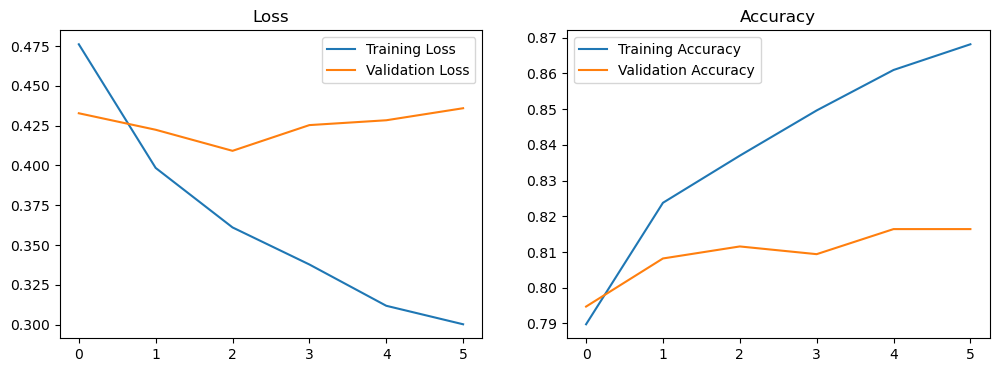

In [5]:
def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 =  "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Au\\"
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA2\\Tp\\"
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}')

# Create EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, reduce_learningrate]

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model using the generators
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)

# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()